In [28]:
# ENVIRONMENT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms


from torch.autograd import Variable

In [91]:
# PREPARING THE DATASET
## Hyper parameters

n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enable = False
torch.manual_seed(random_seed)


In [92]:
## Load MNIST dataset in a handy way

train_loader = torch.utils.data.DataLoader(
    dsets.MNIST('/home/bdggj/Documents/Deep_learning_exercise/hand_written_digits_recog/files/', train=True, download=True, 
                transform=transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.1307,), (0.3081,))
                                             ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dsets.MNIST('/home/bdggj/Documents/Deep_learning_exercise/hand_written_digits_recog/files/', train=False, download=True, 
                transform=transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.1307,), (0.3081,))
                                             ])),
    batch_size=batch_size_test, shuffle=True)

In [93]:
## examples

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


In [94]:
example_data.shape

torch.Size([1000, 1, 28, 28])

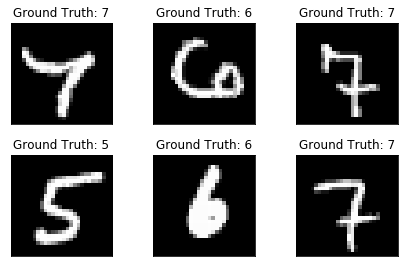

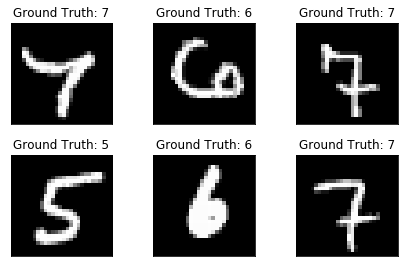

In [95]:
## show some pics

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    
fig

In [96]:
# BUILDING THE NETWORK

# 3-D convolutional layers followed by two fully-connected layers

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50,10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)  #flat the features from (20, 4, 4) to (1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    

In [97]:
network = Net()
network.cuda() # use a GPU ofr training
print(network)

optimizer = optim.SGD(network.parameters(), lr=learning_rate, 
                     momentum=momentum)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [98]:
# TRAINING THE MODEL

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [99]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.cuda()
        target=target.cuda()
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)  #calculate the negative log likeligood loss
        loss.backward()
        optimizer.step() #renew the parameters
        if batch_idx % log_interval == 0:
             print ('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
             epoch, batch_idx * len(data), len(train_loader.dataset),
             100. *batch_idx / len(train_loader), loss.item()))
        
             train_losses.append(loss.item())
             train_counter.append(
                 (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
             torch.save(network.state_dict(), 
                        '/home/bdggj/Documents/Deep_learning_exercise/hand_written_digits_recog/results/model.pth')
             torch.save(optimizer.state_dict(), 
                        '/home/bdggj/Documents/Deep_learning_exercise/hand_written_digits_recog/results/optimizer.pth')
        

In [100]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data=data.cuda()
            target=target.cuda()
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1].cuda()
            correct += pred.eq(target.data.view_as(pred)).sum()
        
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
        

In [101]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/bdggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.278280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279660
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.263015
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.256495
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301418
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.188039
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.182298
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.073817
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.031979
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.079804
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.931658
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.736195
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.908807
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.755384
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.446099
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.505101
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.325090
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.453677
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.301913
Train Epoch: 1 [12160/6

Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.383572
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.589600
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.709626
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.427140
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.416961
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.345559
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.177977
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.273763
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.252160
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.392428
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.307067
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.329433
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.252385
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.413544
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.482838
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.422406
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.570844
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.579955
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.397591
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.196537


Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.281502
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.508788
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.217840
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.251055
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.315807
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.333552
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.248828
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.232396
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.305835
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.189531
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.140490
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.146731
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.120886
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.135887
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.405184
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.301903
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.133994
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.236252
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.171050
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.365364
